# Background Estimate

**Goal:** I wanted to be able to get stats only limits with my trained, GNN, so for the background estimate, I'm going w/ Rafael and Sean's background estimate, and this notebook is [modified from Rafael's](https://gitlab.cern.ch/hh4b/hh4b-background-estimation/blob/nn-reweighting/Resolved/nn-reweighting-notebook/NNReweighting.ipynb).

I don't have tensorflow working in my singularity image, so I'm using Rafael's conda env.

`source /gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/bin/activate py3`

**Note:** I was stupid and didn't save enough information when processing this dataset, this doesn't have any of the analysis cuts applied, and I didn't save the masks to apply the cuts myself.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os

%load_ext autoreload
%autoreload 2

My `processData.py` iterates over the files in each period, so now I need to concatenate the periods.

In [2]:
nSelectedJets = 5

subDir = 'data_16_PFlow-MAY2019'
if nSelectedJets != 4:
    subDir += f'-{nSelectedJets}jets'

fDir = f"../data/{subDir}/"

In [3]:
fout = f"{fDir}df_f_0.22_fullmassplane.h5"
df = pd.read_hdf(fout,key='df')

# The reweighting
df['kinematic_region'] = -1
df.loc[df.SR,'kinematic_region'] = 0 
df.loc[df.CR,'kinematic_region'] = 1
df.loc[df.SB,'kinematic_region'] = 2

# Apply the cuts up to Xwt
df['cut_deta_hh'] = (df.deta_hh < 1.5) & (df.MDpT)
df['cut_Xwt'] = (df.Xwt > 1.5) & (df.cut_deta_hh)
data16 = df[df.cut_deta_hh]

In [4]:
# filename="/u/ki/nhartman/gpfs/hh4b-resolved-reconstruction/data16_topo_2016triggers.root"
# tree = uproot.open(filename)["fullmassplane"]

# data16 = tree.pandas.df()

In [5]:
len(data16.index)

1353473

In [6]:
data16.columns

Index(['m4j', 'nbtags', 'Xwt', 'deta_hh', 'HC1_m', 'HC2_m', 'HC1_vecSum_pt',
       'HC2_vecSum_pt', 'HC1_dRjj', 'HC2_dRjj', 'MDR', 'MDpT', 'SR', 'CR',
       'SB', 'njets', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2', 'pt_hh',
       'kinematic_region', 'cut_deta_hh', 'cut_Xwt'],
      dtype='object')

In [7]:
# df_2b_SB['ntag'] = 2
# df_4b_SB['ntag'] = 4 # fine to combine the 4 and >= 4 categories

# df_2b_SB['kinematic_region'] = 2
# df_4b_SB['kinematic_region'] = 2

# data16 = pd.concat([df_2b_SB,df_4b_SB])

In [8]:
to_log = [ 'pT_4', 'pT_2', 'dRjj_1', 'dRjj_2', 'pt_hh' ]

In [9]:
for tl in to_log:
    data16[tl+'_log'] = np.log(data16[tl])

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
sort_rw_cols = ['pT_4_log', 'pT_2_log', 'eta_i', 'dRjj_1_log', 'dRjj_2_log', 'njets', 'pt_hh_log']

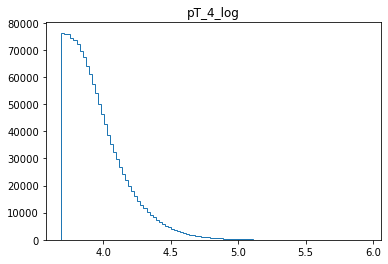

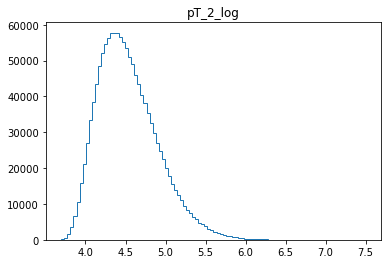

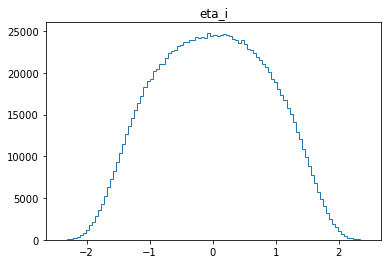

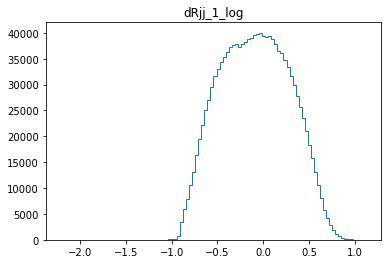

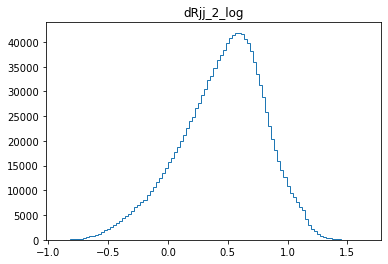

In [11]:
for rw in sort_rw_cols:
    plt.figure()
    plt.hist(data16[rw], bins=100, histtype='step')
    plt.title(rw)
    plt.show()

In [12]:
# Harmonize w/ the NNT naming convention
data16['ntag'] = data16['nbtags']
data16['m_hh'] = data16['m4j']

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
original = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),sort_rw_cols]
target = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),sort_rw_cols]

In [14]:
original_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),sort_rw_cols]
target_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),sort_rw_cols]

In [15]:
original_sr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 0),sort_rw_cols]

In [16]:
original_mass = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),"m_hh"]
target_mass = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),"m_hh"]

In [17]:
original_mass_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),"m_hh"]
target_mass_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),"m_hh"]

In [18]:
original_mass_sr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 0),"m_hh"]

Ok, I will have to re-run my `processData.py` script also saving `m_hh_cor` if I want to save this functionality as well.

I think it's fine to table this for the first pass though - especially b/c for the NR limit we probably won't even want to do this kinematic rescaling step.

In [19]:
# original_mass_corr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),"m_hh_cor"]
# target_mass_corr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),"m_hh_cor"]

In [20]:
# original_mass_corr_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),"m_hh_cor"]
# target_mass_corr_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),"m_hh_cor"]

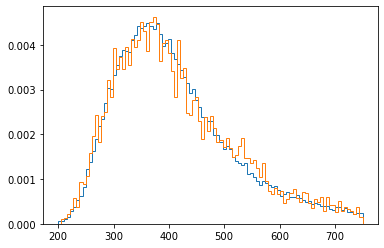

In [21]:
plt.figure()
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, label='original')
plt.hist(target_mass, bins=100, histtype='step', range=(200,750), density=1, label='target')
plt.show()

In [22]:
X_all = pd.concat((original, target), ignore_index=True).values

In [23]:
Y_all = []
for _df, ID in [(original,1), (target, 0)]:
    Y_all.extend([ID] * _df.shape[0])
Y_all = np.array(Y_all)

In [24]:
print('split')
from sklearn.model_selection import train_test_split

split


In [25]:
ix = range(X_all.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, Y_train, Y_test, ix_train, ix_test = train_test_split(
    X_all, Y_all, ix, train_size=0.6)

In [26]:
print('scale')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scale


In [27]:
import keras.backend as K

Using TensorFlow backend.


In [28]:
def louppe_loss(y_true, y_pred):
    # Our loss
    return (y_true * (K.sqrt(K.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [29]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

In [30]:
X_all.shape

(86641, 7)

In [31]:
inputs = Input(shape=(X_all.shape[1], ))
hidden = Dense(20, activation='relu')(inputs)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(20, activation='relu')(hidden)
outputs = Dense(1, activation='linear')(hidden)

model = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss=louppe_loss, metrics=['accuracy'], optimizer="adam")

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
history = model.fit(X_train, Y_train,
                        callbacks = [
                                EarlyStopping(monitor='val_loss', patience=20, verbose=True),
                                ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                                epochs=100,
                                validation_split = 0.2,
                                batch_size=1024,
                       )

Instructions for updating:
Use tf.cast instead.
Train on 41587 samples, validate on 10397 samples
Epoch 1/100
41587/41587 [==============================] - 1s 25us/step - loss: 0.8699 - acc: 0.0612 - val_loss: 0.6871 - val_acc: 6.7327e-04

Epoch 00001: val_loss improved from inf to 0.68710, saving model to current_model.h5
Epoch 2/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.6232 - acc: 7.2138e-05 - val_loss: 0.5939 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.68710 to 0.59389, saving model to current_model.h5
Epoch 3/100
41587/41587 [==============================] - 0s 6us/step - loss: 0.5851 - acc: 0.0000e+00 - val_loss: 0.5836 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.59389 to 0.58358, saving model to current_model.h5
Epoch 4/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.5757 - acc: 0.0000e+00 - val_loss: 0.5767 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.58358 to 0.57666, sa

41587/41587 [==============================] - 0s 5us/step - loss: 0.5439 - acc: 7.6947e-04 - val_loss: 0.5550 - val_acc: 1.9236e-04

Epoch 00036: val_loss did not improve from 0.55467
Epoch 37/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.5439 - acc: 8.1756e-04 - val_loss: 0.5552 - val_acc: 6.7327e-04

Epoch 00037: val_loss did not improve from 0.55467
Epoch 38/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.5435 - acc: 6.7329e-04 - val_loss: 0.5551 - val_acc: 0.0000e+00

Epoch 00038: val_loss did not improve from 0.55467
Epoch 39/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.5435 - acc: 8.1756e-04 - val_loss: 0.5554 - val_acc: 8.6563e-04

Epoch 00039: val_loss did not improve from 0.55467
Epoch 40/100
41587/41587 [==============================] - 0s 5us/step - loss: 0.5434 - acc: 7.6947e-04 - val_loss: 0.5551 - val_acc: 8.6563e-04

Epoch 00040: val_loss did not improve from 0.55467
Epoch 41/100
41587/4158

In [36]:
yhat_orig = model.predict( scaler.transform(original.values), batch_size=1024 )
yhat_targ = model.predict( scaler.transform(target.values), batch_size=1024 )

In [37]:
yhat_orig_cr = model.predict( scaler.transform(original_cr.values), batch_size=1024 )
yhat_targ_cr = model.predict( scaler.transform(target_cr.values), batch_size=1024 )

In [38]:
yhat_orig_sr = model.predict( scaler.transform(original_sr.values), batch_size=1024 )

In [39]:
yhat_orig_sr.shape

(29138, 1)

In [40]:
original_sr.shape

(29138, 7)

In [41]:
original_mass_sr.shape

(29138,)

In [42]:
print(yhat_orig)

[[-2.4068341]
 [-2.48316  ]
 [-2.7548392]
 ...
 [-2.5701153]
 [-2.3883116]
 [-2.5150325]]


In [43]:
plt.figure()
plt.hist((yhat_orig), bins=100, histtype='step', label='orig')
plt.hist((yhat_targ), bins=100, histtype='step', label='target')
plt.legend()
plt.show()

In [44]:
sort_rw_cols

['pT_4_log',
 'pT_2_log',
 'eta_i',
 'dRjj_1_log',
 'dRjj_2_log',
 'njets',
 'pt_hh_log']

In [45]:
#rw_labels = ['$\log p_4$','$\log p_2$',$$]

In [46]:
dataText = "$\mathbf{ATLAS}$ data Internal\n"
dataText += "2016 data MAY2019 prod w/ pairAGraph"

In [47]:
subDir

'data_16_PFlow-MAY2019-5jets'

In [48]:
figDir = f'figures/{subDir}/xformer_train_SMNR_mc16ade/'

In [49]:
figDir

'figures/data_16_PFlow-MAY2019-5jets/xformer_train_SMNR_mc16ade/'

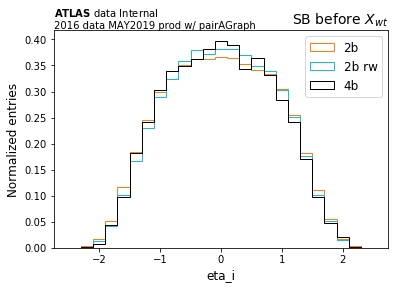

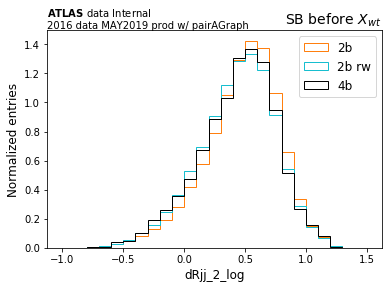

In [50]:
nBinsCont = 25
nBins = [nBinsCont]*5+[8]+[nBinsCont]

myRange = [(3.5,5),(3.5,6.5),(-2.5,2.5),(-1,1),(-1,1.5),(3.5,11.5),(-2,7)]

for rw,b,r in zip(sort_rw_cols,nBins,myRange):
    
    plt.figure()
    plt.hist(original[rw], b,r,color='C1',density=1, histtype='step', label='2b')
    plt.hist(original[rw], b,r,color='C9',density=1, histtype='step', weights=np.exp(yhat_orig), label='2b rw')
    plt.hist(target[rw],   b,r,color='k', density=1, histtype='step', label='4b')
    plt.title('SB before $X_{wt}$',loc='right',fontsize=14)
    plt.xlabel(rw,fontsize=12)
    plt.ylabel("Normalized entries",fontsize=12)
    
    ax = plt.gca()
    ax.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

    plt.legend(fontsize=12)
    plt.savefig(f'{figDir}/rw_NN/{rw}_SB_preXwt.pdf')
    plt.show()

In [51]:
# nBinsCont = 25
# nBins = [nBinsCont]*5+[8]+[nBinsCont]

# myRange = [(3.5,5),(3.5,6.5),(-2.5,2.5),(-1,1),(-1,1.5),(3.5,11.5),(-2,7)]

# for rw,b,r in zip(sort_rw_cols,nBins,myRange):
    
#     plt.figure()
#     plt.hist(original[rw], b,r,color='C1',density=1, histtype='step', label='2b')
#     plt.hist(original[rw], b,r,color='C9',density=1, histtype='step', weights=np.exp(yhat_orig), label='2b rw')
#     plt.hist(target[rw],   b,r,color='k', density=1, histtype='step', label='4b')
#     plt.title('SB before $X_{wt}$',loc='right',fontsize=14)
#     plt.xlabel(rw,fontsize=12)
#     plt.ylabel("Normalized entries",fontsize=12)
    
#     ax = plt.gca()
#     ax.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

#     plt.legend(fontsize=12)
#     plt.savefig(f'{figDir}/rw_NN/{rw}_SB_preXwt.pdf')
#     plt.show()

Make the same plots - but prettier!

In [52]:
for kk in data16.keys():
    print(kk)

m4j
nbtags
Xwt
deta_hh
HC1_m
HC2_m
HC1_vecSum_pt
HC2_vecSum_pt
HC1_dRjj
HC2_dRjj
MDR
MDpT
SR
CR
SB
njets
pT_2
pT_4
eta_i
dRjj_1
dRjj_2
pt_hh
kinematic_region
cut_deta_hh
cut_Xwt
pT_4_log
pT_2_log
dRjj_1_log
dRjj_2_log
pt_hh_log
ntag
m_hh


In [53]:
plt.figure()
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, label='original')
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, weights=np.exp(yhat_orig), label='original weighted')
plt.hist(target_mass, bins=100, histtype='step', range=(200,750), density=1, label='target')
plt.legend()
plt.show()

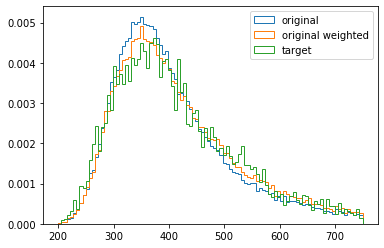

In [54]:
plt.figure()
plt.hist(original_mass_cr, bins=100, histtype='step', range=(200,750), density=1, label='original')
n_2b,edg,_ = plt.hist(original_mass_cr, bins=100, histtype='step', range=(200,750), density=1, weights=np.exp(yhat_orig_cr), label='original weighted')
n_4b,edg,_ = plt.hist(target_mass, bins=100, histtype='step', range=(200,750), density=1, label='target')
plt.legend()
plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


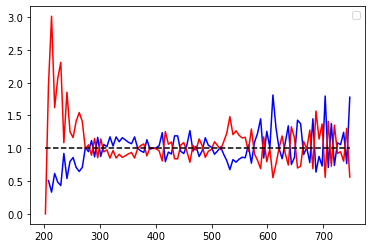

In [55]:
x = 0.5 * (edg[1:]+edg[:-1])
plt.figure()
plt.plot(x,n_2b/n_4b,'b')
plt.plot(x,n_4b/n_2b,'r')
plt.plot(x,np.ones_like(x),'k--')
plt.legend()
plt.show()

Oh - what we want to compare is the bkg estimate in the SB and CR. 

But I *have* a bkg estimate - let's *get a limit*!

In [56]:
import pyhf

In [57]:
os.sys.path.append('../code')
from AnalysisUtils import *

In [58]:
# Load in the signal

sigSubDir = 'SMNR_mc16a_PFlow-AUG2019-5jets'
sig_df = pd.read_hdf(f"../data/{sigSubDir}/test_df_f_0.22_3b_scaledInputs_withCuts.h5", key='df')


In [59]:
df.columns

Index(['m4j', 'nbtags', 'Xwt', 'deta_hh', 'HC1_m', 'HC2_m', 'HC1_vecSum_pt',
       'HC2_vecSum_pt', 'HC1_dRjj', 'HC2_dRjj', 'MDR', 'MDpT', 'SR', 'CR',
       'SB', 'njets', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2', 'pt_hh',
       'kinematic_region', 'cut_deta_hh', 'cut_Xwt'],
      dtype='object')

In [60]:
yhat_orig.shape

(79246, 1)

In [61]:
np.sum((df.kinematic_region==2) & (df.nbtags==2)&(df.cut_deta_hh))

79246

In [62]:
np.sum(np.exp(yhat_orig))

7105.5645

In [63]:
np.sum((data16.kinematic_region==2)&(data16.nbtags >= 4))

7395

In [64]:
np.sum((df.kinematic_region==2) & (df.nbtags>=4)&(df.cut_deta_hh))

7395

In [65]:
N2bTo4b = np.sum((data16.kinematic_region==2)&(data16.nbtags >= 4)) / np.sum(np.exp(yhat_orig))

In [66]:
N2bTo4b

1.0407336459734324

In [67]:
bins = np.linspace(100,1400,66)
sig_SR = (sig_df.cut_Xwt &  (sig_df.kinematic_region==0) & (sig_df.nbtags==4))
s,_ = np.histogram(sig_df.loc[sig_SR,'m4j'],bins,weights=sig_df.loc[sig_SR,'mc_sf'])

bkg_SR = df.loc[(df.kinematic_region==0) & (df.nbtags==2)&(df.cut_deta_hh),'cut_Xwt']
b,_ = np.histogram(original_mass_sr[bkg_SR],bins,
                   weights=N2bTo4b*np.exp(yhat_orig_sr.squeeze())[bkg_SR])

In [68]:
np.sum(s), np.sum(b)

(4.089613978362317, 2636.66)

In [69]:
np.sum(s)/ np.sum(b)

0.0015510585796749772

In [70]:
np.sum(s)/ np.sqrt(np.sum(b))

0.0796444047691659

In [71]:
np.sum((df.kinematic_region==0) & (df.nbtags==2))

68597

In [72]:
np.sum(bkg_SR)

27847

In [73]:
original_mass_sr.shape

(29138,)

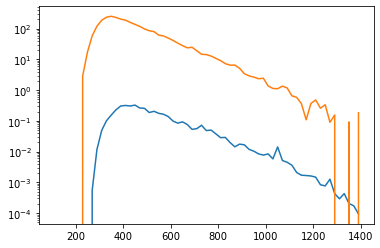

In [74]:
x = 0.5*(_[1:]+_[:-1])
plt.semilogy(x,s)
plt.semilogy(x,b)
plt.show()

In [75]:
from matplotlib import gridspec

In [76]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

In [77]:
smText = "$\mathbf{ATLAS}$ Internal\n"
smText += "2016 data and SMNR mc16a"

Maybe I could overlay the baseline on top of this?

In [115]:
mc_fileName   = "../../public/hh4b/nanoNtuples/NNT_AUG19_pflow/450000_mc16a/nominal.root"
data_fileName = "../../public/hh4b/nanoNtuples/NNT_AUG19_pflow/data16_with_weights.root"

treeName = 'fullmassplane'

pflow_smnr   = nanoToDf(mc_fileName.format("pflow"),ttree=treeName)
pflow_data16 = nanoToDf(data_fileName.format("pflow"),ttree=treeName)

pflow_smnr = pflow_smnr[pflow_smnr.run_number > 296939]
pflow_smnr.loc[pflow_smnr.mc_sf < -0.002,'mc_sf'] = 0

fullmassplane
fullmassplane


In [80]:
np.min(pflow_smnr.run_number)

297730

In [118]:
L = 3.2195+24.5556
#L = 24.3+3.2
pflow_sig = (pflow_smnr.kinematic_region==0) & (pflow_smnr.ntag>=4)
pflow_bkg = (pflow_data16.kinematic_region==0) & (pflow_data16.ntag==2)

In [119]:
L*np.sum(pflow_smnr.loc[pflow_sig,'mc_sf'])

3.8694221113236296

In [120]:
norm = np.sum((pflow_data16.kinematic_region==2) & (pflow_data16.ntag>=4)) / np.sum((pflow_data16.kinematic_region==2) & (pflow_data16.ntag==2))
pflow_data16['w_2b'] = norm * pflow_data16['BDT_d24_weight_16']

In [84]:
np.sum(pflow_data16.loc[(pflow_data16.kinematic_region==2) & (pflow_data16.ntag==2),'BDT_d24_weight_16'])

1342090.0525310296

In [85]:
np.sum(pflow_data16.loc[(pflow_data16.kinematic_region==2) & (pflow_data16.ntag==2),'BDT_d24_weight_16'])/np.sum((pflow_data16.kinematic_region==2) & (pflow_data16.ntag==2))

0.896334726186131

In [86]:
-0.006009*L

-0.1669005759

In [87]:
np.min(sig_df.mc_sf)

-0.1174120407125643

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


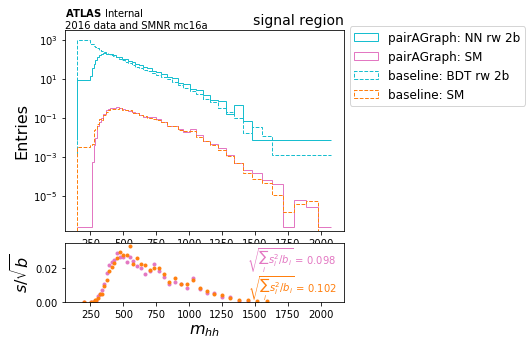

In [121]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

bkg_SR = df.loc[(df.kinematic_region==0) & (df.nbtags==2)&(df.cut_deta_hh),'cut_Xwt']
b,_,_ = ax1.hist(original_mass_sr[bkg_SR],
                 edges,color='C9',histtype='step',log=True,
                 label='pairAGraph: NN rw 2b',
                 weights=np.exp(yhat_orig_sr.squeeze())[bkg_SR])

sig_SR = (sig_df.cut_Xwt &  (sig_df.kinematic_region==0) & (sig_df.nbtags==4))
s,_,_ = ax1.hist(sig_df.loc[sig_SR,'m4j'],
                 edges,color='C6',histtype='step',log=True,
                 label='pairAGraph: SM',
                 weights=sig_df.loc[sig_SR,'mc_sf'])


b0,_,_ = ax1.hist(pflow_data16.loc[pflow_bkg,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='baseline: BDT rw 2b',linestyle='--',
                 weights=pflow_data16.loc[pflow_bkg,'w_2b'])

s0,_,_ = ax1.hist(pflow_smnr.loc[pflow_sig,'m_hh'],
                 edges,color='C1',histtype='step',log=True,
                 label='baseline: SM',linestyle='--',
                 weights=L*pflow_smnr.loc[pflow_sig,'mc_sf'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C6',linewidth=0)
ax2.plot(0.5*(edges[:-1]+edges[1:]),s0/np.sqrt(b0),marker='.',color='C1',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,.95,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C6')
ax2.text(.975,.475,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C1')

ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

#ax1.legend(fontsize=10,loc="upper right")
ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))

ax1.set_title('signal region', loc='right',fontsize=14)

#plt.savefig('figures/min_dRjj1/m_hh_SR_log_ratio.pdf',bbox_inches='tight')

plt.show()

In [89]:
np.sum(s0)#/L*(24.3+3.2)

3.702511522807359

In [90]:
np.sum(s0),np.sum(b0)

(3.702511522807359, 5761.671668103896)

In [91]:
original_mass_sr.shape

(29138,)

In [92]:
yhat_orig_sr.shape

(29138, 1)

In [93]:
os.listdir("../data/data_16_PFlow-MAY2019-5jets")

['files',
 'df_periodABCDEFG_f_0.22_fullmassplane.h5',
 'df_periodABC_f_0.22_fullmassplane.h5',
 'old_files',
 'df_f_0.22_2b.h5',
 'df_f_0.22_fullmassplane.h5',
 'df_f_0.22_3b.h5',
 'df_f_0.22_rw_vars.h5',
 'df_f_0.22_2b_SB_rw_vars.h5',
 'df_f_0.22_4b_SB_rw_vars.h5']

In [94]:
mus = np.linspace(1,40, 40)
    
mj = simple(list(s), list(b))

# Do the fit
# Get the scan over mu
hypo_tests = [pyhf.utils.hypotest(mu, mj.expected_data([0]), mj,
                                  [0.5], [(0,np.max(mus))],
                                  return_expected_set=True,
                                  return_test_statistics=True,
                                  qtilde=True) for mu in mus]

cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

alpha=0.05
stat_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
             for y_vals in cls_exp]

#stat 
for k,v in zip(range(-2,3),stat_band):
    print(k,v)
    #stat[k].append(v)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


-2 10.818995417767304
-1 14.580141814147293
0 20.333059768246628
1 28.49605853843707
2 38.52844282592848


In [116]:
mi = simple(list(s0), list(b0))

# Do the fit
# Get the scan over mu
hypo_tests = [pyhf.utils.hypotest(mu, mi.expected_data([0]), mi,
                                  [0.5], [(0,np.max(mus))],
                                  return_expected_set=True,
                                  return_test_statistics=True,
                                  qtilde=True) for mu in mus]

cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

alpha=0.05
stat_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
             for y_vals in cls_exp]

#stat 
for k,v in zip(range(-2,3),stat_band):
    print(k,v)
    #stat[k].append(v)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


-2 10.541777894735285
-1 14.176283867863557
0 19.793208302575106
1 27.770794589384348
2 37.61123596388897


Ok, atm the reweighting extrapolation looks really bad, but I think this is because of the $X_{wt}$ stripe for the W-veto in the massplane, so I just need to derive the background estimate before $X_{wt}$ and apply it afterwards. Since I have a dataset that includes events before the $X_{wt}$ cut in *another nb*.

Save these weights for future use.

In [96]:
data16['w2b'] = 1
data16.loc[(data16.ntag==2) & (data16.kinematic_region==2),'w2b'] = np.exp(yhat_orig)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [97]:
data16.w2b

0          1.0000
2          0.0901
4          1.0000
7          1.0000
11         1.0000
            ...  
5023568    1.0000
5023570    1.0000
5023571    1.0000
5023582    1.0000
5023584    1.0000
Name: w2b, Length: 1353473, dtype: float64

In [98]:
# fout = f"{fDir}df_f_0.22_rw_vars.h5"
# data16.to_hdf(fout,key='df',mode='w')

Ok, what I actually need is to train this model in the CR...

Ok, Rafael also wanted me to do the background estimate with the BDT + pairAGraph...

In [102]:
getBDTWeights(data16,"pairAGraph_BDT.p",trainBDT=True)

Training on columns: ['pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'njets']


../code/AnalysisUtils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[key] = N4bTo2b * reweighter.predict_weights(data[sort_rw_cols])


Look at the plots

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


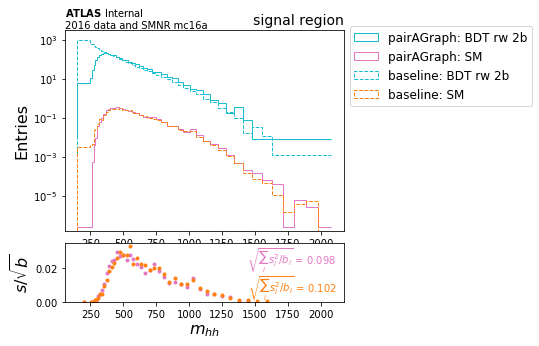

In [122]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

bkg_SR = df.loc[(df.kinematic_region==0) & (df.nbtags==2)&(df.cut_deta_hh),'cut_Xwt']
b1,_,_ = ax1.hist(original_mass_sr[bkg_SR],
                  edges,color='C9',histtype='step',log=True,
                  label='pairAGraph: BDT rw 2b',
                  weights=data16.loc[(df.kinematic_region==0) & (df.nbtags==2)&(df.cut_Xwt),'w_2b'])

sig_SR = (sig_df.cut_Xwt &  (sig_df.kinematic_region==0) & (sig_df.nbtags==4))
s1,_,_ = ax1.hist(sig_df.loc[sig_SR,'m4j'],
                 edges,color='C6',histtype='step',log=True,
                 label='pairAGraph: SM',
                 weights=sig_df.loc[sig_SR,'mc_sf'])


b0,_,_ = ax1.hist(pflow_data16.loc[pflow_bkg,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='baseline: BDT rw 2b',linestyle='--',
                 weights=pflow_data16.loc[pflow_bkg,'w_2b'])

s0,_,_ = ax1.hist(pflow_smnr.loc[pflow_sig,'m_hh'],
                 edges,color='C1',histtype='step',log=True,
                 label='baseline: SM',linestyle='--',
                 weights=L*pflow_smnr.loc[pflow_sig,'mc_sf'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s1/np.sqrt(b1),marker='.',color='C6',linewidth=0)
ax2.plot(0.5*(edges[:-1]+edges[1:]),s0/np.sqrt(b0),marker='.',color='C1',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,.95,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C6')
ax2.text(.975,.475,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C1')

ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

#ax1.legend(fontsize=10,loc="upper right")
ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig(f'figures/{subDir}/m_hh_SR_log_ratio_BDT.pdf',bbox_inches='tight')

plt.show()

In [106]:
np.sum(b1)

2457.2815262273466

In [123]:
mj = simple(list(s1), list(b1))

# Do the fit
# Get the scan over mu
hypo_tests = [pyhf.utils.hypotest(mu, mj.expected_data([0]), mj,
                                  [0.5], [(0,np.max(mus))],
                                  return_expected_set=True,
                                  return_test_statistics=True,
                                  qtilde=True) for mu in mus]

cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

alpha=0.05
stat_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
             for y_vals in cls_exp]

#stat 
for k,v in zip(range(-2,3),stat_band):
    print(k,v)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


-2 10.591239986680664
-1 14.248286155456816
0 19.87259205722725
1 27.858485920712578
2 37.68554565130431


In [113]:
np.sum(b1),np.sum(s1)/np.sum(b1), np.sum(s1)/np.sqrt(np.sum(b1))

(2457.2815262273466, 0.0016644861291012524, 0.08251019968537528)